# Práctica 11: Inferencias en Redes de Bayes usando factores
### Autor:  Arrieta Mancera Luis Sebastian

### Factor.py

In [87]:
from itertools import product

class Variable:

    """
        Variable Aleatoria
    """

    def __init__(self, nombre, valores_posibles) -> None:
        self.nombre = nombre
        self.valores_posibles = valores_posibles

    def __str__(self) -> str:
        return "Nombre: {} | Valores: {}".format(self.nombre, self.valores_posibles)

class Factor:

    """
        Factor
    """

    def __init__(self, alcance, valores) -> None:
        self.alcance = alcance
        self.valores = valores
        self.tabla = None

    def _generar_tabla_de_valores(self):

        """
            Genera la la tabla de valores del factor
        """

        # Variables aleatorias del factor
        variables = [var.valores_posibles for var in self.alcance]
        # Permutaciones
        combinaciones = list(product(*variables))

        # Resultado
        tabla_valores = []

        # Iteramos sobre las combinaciones y agregamos las filas
        for x in combinaciones:
            fila = dict(zip([var.nombre for var in self.alcance], x))
            fila['Prob'] = self.valores[combinaciones.index(x)] # Agrega el atributo valores del factor
            tabla_valores.append(fila)

        # Establecemos la tabla del factor
        self.tabla = tabla_valores

    def index(self,dir):

        """
            Metodo auxiliar que recibe como parametro
            un diccionario, cuyas llabes sean variables
            y los valores sean el valor asignado a cada
            una.

            param: diccionario
            return: el indice del diccionario pasado
            como parametro en la tabla factor.
        """

        # Lista de los valores a buscar
        valores = []
        for i in range(len(self.alcance)):
            key = self.alcance[i]
            valor = dir[key]
            valores.append(valor)

        # Uso del polinomio de direccionamiento
        return self.pol(0,valores)

    def pol(self, i, valores):

        """
            Implementacion recursiva del polinomio
            de direccionamiento. Regresa el indice
            de un conjunto de valores a buscar en
            la tabla.

            param: i : indice de la variable aleatoria actual
            param: valores: lista de valores a buscar
            return: indice
        """

        if len(valores) == 1:
            return self.pos(valores[0],i)

        # Multiplicacion de longitudes
        mult = 1
        for v in self.alcance[i+1::]:
            mult *= len(v.valores_posibles)

        # Posicion del valor en la variable aleatoria
        pos = self.pos(valores[0],i)
        valores.pop(0)

        # Llamada recursiva
        return ( pos * mult) + self.pol(i+1,valores)

    def pos(self, valor, i):

        """
            Regresa el indice de un valor
            en los posibles valores de la
            variable.

            param: posible valor de la variable
            param: indice de la variable aleatoria
            en el alcance del factor.
            return: indice
        """

        variable = self.alcance[i]
        indice = variable.valores_posibles.index(valor)
        return indice

    def multiply(self,factor):

        """
            Multiplicacion

            param: factor a multiplicar
            return: un nuevo factor resultado
            de la multiplicacion por el factor
            pasado como parametro.
        """

        # Encontrar variables comunes en ambos factores
        variables_comunes = set(self.alcance).intersection(factor.alcance)

        # Combinar alcance y valores de ambos factores
        nuevo_alcance = list(self.alcance) + [var for var in factor.alcance if var not in variables_comunes]
        nuevo_valores = []

        # Permutaciones sobre los posibles valores de las variables
        for combo in product(*[var.valores_posibles for var in nuevo_alcance]):
            fila_factor1 = {var: valor for var, valor in zip(nuevo_alcance, combo)}
            fila_factor2 = {var: valor for var, valor in zip(nuevo_alcance, combo)}
            nuevo_valores.append(self.valores[self.index(fila_factor1)] * factor.valores[factor.index(fila_factor2)])

        return Factor(nuevo_alcance, nuevo_valores)

    def reduce(self, variable, valor):

        """
            Reduccion

            param: variable: variable a reducir
            param: valor: valor a reducir
            return: nuevo factor resultado
            de la reduccion.
        """

        # Extraemos las variables existentes al aplicar la reduccion
        nuevas_variables = [var for var in self.alcance if var != variable]

        if not nuevas_variables:
            # Si no hay variables nuevas despues de la reduccion, devolver una copia del factor original
            return Factor(self.alcance, self.valores.copy())

        nuevo_alcance = tuple(nuevas_variables)
        nuevo_valores = []

        # Permutaciones sobre los posibles valores de las variables
        for combo in product(*[var.valores_posibles for var in nuevo_alcance]):
            fila_factor = {var: valor for var, valor in zip(nuevo_alcance, combo)}
            fila_completa = {**fila_factor, variable: valor}
            nuevo_valores.append(self.valores[self.index(fila_completa)])

        return Factor(nuevo_alcance, nuevo_valores)

    def normalize(self):

        """
            Normalizacion

            return: nuevo factor
            resultado de la
            normalizacion
        """

        # Sumamos los valores
        suma_valores = sum(self.valores)
        if suma_valores != 0:
            # A cada valor lo dividimos por la suma de todos los valores
            valores_normalizados = [valor / suma_valores for valor in self.valores]
            return Factor(self.alcance, valores_normalizados)
        else:
            # Si la suma es 0 regresamos una copia del factor actual
            return Factor(self.alcance, self.valores.copy())

    def marginalize(self, variable):

        """
            Marginalizacion

            param: variable: La variable que se eliminara al marginalizar.
            return: nuevo factor resultado de la marginalización.
        """

        nuevas_variables = [var for var in self.alcance if var != variable]
        if not nuevas_variables:
            # Si no hay variables nuevas despues de la marginalizacion, devolver una copia del factor original
            return Factor(self.alcance, self.valores.copy())

        nuevo_alcance = tuple(nuevas_variables)
        nuevo_valores = []

        # Permutaciones de los valores de las variables en el nuevo alcance
        for combo in product(*[var.valores_posibles for var in nuevo_alcance]):
            fila_factor = {var: valor for var, valor in zip(nuevo_alcance, combo)}
            fila_completa = {**fila_factor, variable: None}

            # Sumar sobre la variable que se está marginalizando
            suma_valores = sum(self.valores[self.index({**fila_completa, variable: v})] for v in variable.valores_posibles)
            nuevo_valores.append(suma_valores)

        return Factor(nuevo_alcance, nuevo_valores)

    def __str__(self) -> str:

        self._generar_tabla_de_valores()

        resultado = ' '.join([v.nombre for v in self.alcance]) + ' | ' + 'Prob\n'
        for fila in self.tabla:
            valores = [str(fila[n]) for n in [v.nombre for v in self.alcance]]
            resultado += ' '.join(valores) + ' | ' + str(fila['Prob']) + '\n'

        return resultado

## Antecedentes

Hace tres diás el diamante Colossus fue robado del museo de la Ciudad Ladrillos. El Agente Toño está a cargo del caso y cuenta con la siguiente información. Hay cinco personas sospechosas y se desea determinar quiénes participaron en el robo:

- Daniel
- Rita
- Joaquín
- Camelia
- Sam

de donde tendremos cinco variables aleatorias: **DP**, **RP**, **JP**, **CP**, **SP** correspondiendo a la inicial del nombre y la palabra "participó".

In [88]:
# = Variables =

DP = Variable("DP", [0,1]) # Diego participo
RP = Variable("RP", [0,1]) # Rita participo
JP = Variable("JP", [0,1]) # Joaquin participo
CP = Variable("CP", [0,1]) # Camelia participo
SP = Variable("SP", [0,1]) # Sam participo


1. Tanto Daniel como joaquín suelen organizar robos de este tipo. De cada diez casos, Joaquín ha estado en siete y Daniel en cinco

In [89]:
fDP = Factor((DP,), [0.5,0.5]) # P(DP)
fJP = Factor((JP,), [0.3,0.7]) # P(JP)

print(fDP)
print(fJP)

DP | Prob
0 | 0.5
1 | 0.5

JP | Prob
0 | 0.3
1 | 0.7



2. Rita ha participando anteriormente en robos con Daniel y Joaquín, aunque se lleva mejor con Daniel. Además, el empleo E de Rita estaba en riesgo, aunque el reporte no indica si lo perdió o no; la probabilidad de que lo hubiera perdido era del 65 %. Cuando Daniel y Joaquín participaron, ella estuvo con el equipo el 90% de las
ocasiones, si sólo estaba Daniel el 80 %, si sólo estaba Joaquín, el 45 %, y nunca actúa sin alguno de ellos. Si Rita está ocupada con su empleo esas probabilidades se reducen a la mitad.

 **E** =  "Rita perdio el empleo"

In [90]:
# Variables

E = Variable("E", [0,1]) # Rita perdio el empleo

fE = Factor((E,), [0.35,0.65]) # P(E)
fRP_DPJPE = Factor((E,JP,DP,RP), [1,0,0.6,0.4,1-((9/20)/2),(9/20)/2,0.55,0.45,1,0,0.2,0.8,0.55,0.45,0.1,0.9]) # P(RP|DP,JP,E)

print(fE)
print(fRP_DPJPE)

E | Prob
0 | 0.35
1 | 0.65

E JP DP RP | Prob
0 0 0 0 | 1
0 0 0 1 | 0
0 0 1 0 | 0.6
0 0 1 1 | 0.4
0 1 0 0 | 0.775
0 1 0 1 | 0.225
0 1 1 0 | 0.55
0 1 1 1 | 0.45
1 0 0 0 | 1
1 0 0 1 | 0
1 0 1 0 | 0.2
1 0 1 1 | 0.8
1 1 0 0 | 0.55
1 1 0 1 | 0.45
1 1 1 0 | 0.1
1 1 1 1 | 0.9



3. Se sabe que Sam es amigo de Rita, y no le gusta el empleo de Rita.Por lo que, con tal de que lo deje, si ella conservó el empleo la probabilidad de que hubiera participado es del 80% independientemente de que ella participara o no.Si Rita perdió el empleo y participó, la probabilidad de que Sam también estuviera involucrado es del 65 %, si ella no participó, es del 20 %.

In [91]:
fSP_ERP = Factor((E,RP,SP), [0.2,0.8,0.2,0.8,0.8,0.2,0.35,0.65]) # P(SP|E,RP)
print(fSP_ERP)

E RP SP | Prob
0 0 0 | 0.2
0 0 1 | 0.8
0 1 0 | 0.2
0 1 1 | 0.8
1 0 0 | 0.8
1 0 1 | 0.2
1 1 0 | 0.35
1 1 1 | 0.65



4. El alarma del museo fue desactivada, esto se logra mediante el uso de alguno de tres dispositivos: A, B y C, de los cuales debieron haber elegido alguno (DiE = dispositivo elegido). Dependiendo de la pericia de su usuario, puede ser posible retirarlos antes de marcharse o no (DiA = dispositivo abandonado). Camelia trabaja en un laboratorio de electrónica donde se puede tener acceso a estos dispositivos y sabe muy bien cómo usarlos. Si ella participó existe una probabilidad del 20% de que un dispositivo de tipo A haya sido abandonado en el museo, sino, esta probabilidad es del 35 %; ella dejará del dispositivo B con el 40 %, mientras que otro lo hará con un 85 %; sólo en un 10% ella dejará un dispositivo C, mientras que otra persona lo dejára el 45% de la veces.

  **DiE** = "dispositivo elegido"

  **DiA** = "dispositivo abandonado"

In [92]:
# Variables

DiE = Variable("DiE", ["A","B","C"]) # Dispositivo elegido
DiA = Variable("DiA", [0,1]) # Dispositivo abandonado

fDiA_CPDiE = Factor((CP,DiE,DiA), [0.65,0.35,0.15,0.85,0.55,0.45,0.8,0.2,0.6,0.4,0.9,0.1]) # P(DiA|CP,DiE)
print(fDiA_CPDiE)

CP DiE DiA | Prob
0 A 0 | 0.65
0 A 1 | 0.35
0 B 0 | 0.15
0 B 1 | 0.85
0 C 0 | 0.55
0 C 1 | 0.45
1 A 0 | 0.8
1 A 1 | 0.2
1 B 0 | 0.6
1 B 1 | 0.4
1 C 0 | 0.9
1 C 1 | 0.1



5. Joaquín ha trabajado con Camelia en proyectos legales, existe una probabilidad del 15% de que Camelia hubiera aceptado participar en el robo sólo si Joaquín lo hizo y un 1% de que ella no hubiera participado y de hecho, ella hubiera ideado el robo. Si Joaquín no participó ella queda libre de toda sospecha pues no tendría ni conexión ni motivo para participar.



In [93]:
fCP_JP = Factor((JP,CP), [1,0,0.85,0.15]) # P(CP|JP)
print(fCP_JP)

JP CP | Prob
0 0 | 1
0 1 | 0
1 0 | 0.85
1 1 | 0.15



6. Independientemente de que Camelia haya estado ahí para usar el dispositivo, pudo haberse limitado a asesorar a los asaltantes (CA). Se sabe que Daniel la conoce y, de haber participado en el robo, hay un 50% de probabilidades de que le haya pedido asesoría. Si no participó, no hubo quien solicitara la asesoría.

  **CA** = "Camelia asesoró"

In [94]:
# Variables

CA = Variable("CA", [0,1]) # Camelia asesoro

fCA_DP = Factor((DP,CA), [1,0,0.5,0.5]) # P(CA|DP)
print(fCA_DP)

DP CA | Prob
0 0 | 1
0 1 | 0
1 0 | 0.5
1 1 | 0.5



7. Entonces, el dispositivo elegido DiE para el robo dependió de si Camelia dió asesoría o participó el robo. Si Camelia participó en el robo definitivamente eligió el dispositivo C, pero si dió asesoría para que lo usara otra persona habrá sugerido el dispositivo B, si no participó ni asesorando ni en persona, un no especialista había elegido el dispositivo A el 25% de las veces, el B el 40% pues es más comercial y el C el 35 %.

In [95]:
fDiE_CACP = Factor((CA,CP,DiE), [0.25,0.4,0.35,0,0,1,0,1,0,0,0,1]) # P(DiE|CA,CP)
print(fDiE_CACP)

CA CP DiE | Prob
0 0 A | 0.25
0 0 B | 0.4
0 0 C | 0.35
0 1 A | 0
0 1 B | 0
0 1 C | 1
1 0 A | 0
1 0 B | 1
1 0 C | 0
1 1 A | 0
1 1 B | 0
1 1 C | 1



8. La probabilidad de encontrar un dispositivo en el museo DiM depende del dispositivo que haya sido elegido y de que éste sea abandonado por quien lo usó. Si un dispositivo tipo A fue abandonado hay un 97% de probabilidades de que la policía lo encuentre; 99% para un dispositivo B y 90% para un dispositivo C.

  **DiM** = "dispositivo en el museo"

In [96]:
# Variables
DiM = Variable("DiM", [0,1]) # Dispositivo en el museo

fDiM_DiEDiA = Factor((DiE,DiA,DiM), [1,0,0.03,0.97,1,0,0.01,0.99,1,0,0.1,0.9]) # P(DiM|DiE,DiA)
print(fDiM_DiEDiA)

DiE DiA DiM | Prob
A 0 0 | 1
A 0 1 | 0
A 1 0 | 0.03
A 1 1 | 0.97
B 0 0 | 1
B 0 1 | 0
B 1 0 | 0.01
B 1 1 | 0.99
C 0 0 | 1
C 0 1 | 0
C 1 0 | 0.1
C 1 1 | 0.9



9. Para encontrar la ubicación U del diamante se consideran tres posibilidades:

- Sam tiene una caja de seguridad en el banco, si él participó el diamante podría estar ahí.
- Daniel es un mandón, pero algo imprudente, cuando ha participado en un robo frecuentemente los objetos han sido encontrados en su casa.
- A Joaquín no le gusta correr riesgos y considera que Daniel es muy descuidado, pero también es muy metódico. En ocasiones anteriores se ha encontrado el botín enterrado en un punto equidistante a las casas de todos los participantes.

  Si, de ellos tres, sólo Sam participó, el diamante estará en su caja de seguridad. Si Daniel participó, pero no Joaquín, hay un 80% de probabilidades de que esté en casa de Daniel, un 15% en la caja de Sam y un 5% de que le hayan copiado la idea a Joaquín. Si Joaquín participó, pero no Daniel, hay un 65% de probabilidad de que el diamante esté enterrado, un 30% de que esté en la caja y un 5% de que
  lo hayan sembrado en casa de Daniel. Si tanto Daniel como Joaquín estuvieron en el equipo, cualquiera de los tres lugares es igualmente probable... incluso si Sam no participó. Si ninguno de los tres participó la casa de Daniel sigue siendo un buen escondite con el 60 %, el punto central con 30% y la caja de Sam 10 %.

  **U** = "ubicación del diamante"

In [97]:
# Variable

U = Variable("U", ["caja", "casa", "ente"]) # Ubicacion del diamante, valores: "casa", "caja", "enterrado"

fU_SPDPJP = Factor((SP,DP,JP,U), [0.1,0.6,0.3,
                                  0.3,0.05,0.65,
                                  0.15,0.8,0.05,
                                  1/3,1/3,1/3,
                                  1,0,0,
                                  0.3,0.05,0.65,
                                  0.15,0.8,0.05,
                                  1/3,1/3,1/3]) # P(U|SP,DP,JP)
print(fU_SPDPJP)

SP DP JP U | Prob
0 0 0 caja | 0.1
0 0 0 casa | 0.6
0 0 0 ente | 0.3
0 0 1 caja | 0.3
0 0 1 casa | 0.05
0 0 1 ente | 0.65
0 1 0 caja | 0.15
0 1 0 casa | 0.8
0 1 0 ente | 0.05
0 1 1 caja | 0.3333333333333333
0 1 1 casa | 0.3333333333333333
0 1 1 ente | 0.3333333333333333
1 0 0 caja | 1
1 0 0 casa | 0
1 0 0 ente | 0
1 0 1 caja | 0.3
1 0 1 casa | 0.05
1 0 1 ente | 0.65
1 1 0 caja | 0.15
1 1 0 casa | 0.8
1 1 0 ente | 0.05
1 1 1 caja | 0.3333333333333333
1 1 1 casa | 0.3333333333333333
1 1 1 ente | 0.3333333333333333



# Grafica de Bayes


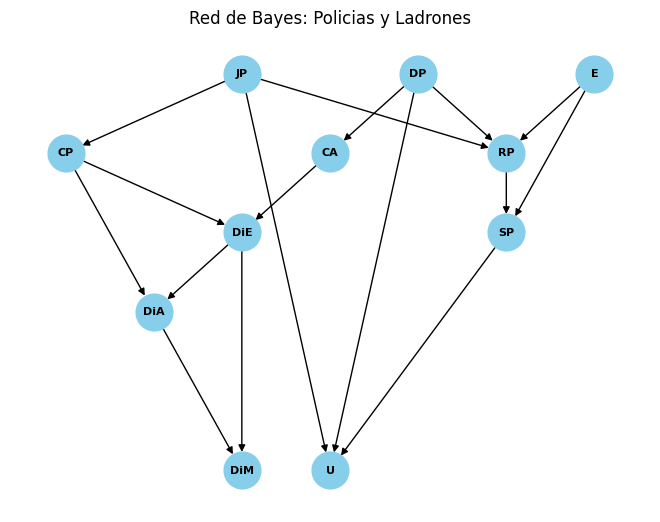

In [98]:
import networkx as nx
import matplotlib.pyplot as plt

# Definir las adyacencias de los nodos
grafo = {
    'DP': ['U', 'CA', 'RP'],
    'RP': ['SP'],
    'JP': ['U', 'RP', 'CP'],
    'CP': ['DiE', 'DiA'],
    'SP': ['U'],
    'E': ['RP', 'SP'],
    'DiE': ['DiA', 'DiM'],
    'DiA': ['DiM'],
    'CA': ['DiE'],
    'DiM': [],
    'U': [],
}

# Definir la posición de cada nodo manualmente
posiciones = {
    'DP': (4, 5),
    'RP': (5, 4),
    'JP': (2, 5),
    'CP': (0, 4),
    'SP': (5, 3),
    'E': (6, 5),
    'DiE': (2, 3),
    'DiA': (1, 2),
    'CA': (3, 4),
    'DiM': (2, 0),
    'U': (3, 0),
}

# Crear un grafo dirigido desde las adyacencias
G = nx.DiGraph(grafo)

# Dibujar el grafo
pos = posiciones  # Posición de los nodos
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black', font_weight='bold', arrowsize=10)

# Mostrar el grafo
plt.title("Red de Bayes: Policias y Ladrones")
plt.show()


# P(U)
$P(U) = P(U|SP,JP,DP)P(SP|E,RP)P(RP|E,JP,DP)P(E)P(JP)P(DP)$
### Ecuacion1
$ = Σ_{SP,JP,DP,E,RP} P(U|SP,JP,DP)P(SP|E,RP)P(RP|E,JP,DP)P(E)P(JP)P(DP)$
### Ecuacion2
$ = Σ_{E}P(E)Σ_{RP,SP}P(SP|E,RP)Σ_{DP}P(DP)Σ_{JP}P(U|SP,JP,DP)P(RP|E,JP,DP)P(JP)$

In [99]:
def ecuacion1():

  # Σ_{SP,JP,DP,E,RP} P(U|SP,JP,DP)P(SP|E,RP)P(RP|E,JP,DP)P(E)P(JP)P(DP)

  # Prob = P(JP) * P(DP)
  Prob = fJP.multiply(fDP)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Prob = P(E) * Prob
  Prob = fE.multiply(Prob)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Prob = P(RP|E,JP,DP) * Prob
  Prob = fRP_DPJPE.multiply(Prob)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Prob = P(SP|E,RP) * Prob
  Prob = fSP_ERP.multiply(Prob)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Prob = P(U|SP,JP,DP) * Prob
  Prob = fU_SPDPJP.multiply(Prob)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))

  # Marginalizacion para Σ_{SP,JP,DP,E,RP}
  Prob = Prob.marginalize(RP)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Marginalizacion para Σ_{SP,JP,DP,E}
  Prob = Prob.marginalize(E)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Marginalizacion para Σ_{SP,JP,DP}
  Prob = Prob.marginalize(DP)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Marginalizacion para Σ_{SP,JP}
  Prob = Prob.marginalize(JP)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Marginalizacion para Σ_{SP}
  Prob = Prob.marginalize(SP)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))

  return Prob


In [100]:
def ecuacion2():

  # Σ_{E} P(E) * Σ_{RP,SP} P(SP|E,RP) * Σ_{DP} P(DP) * Σ_{JP} P(U|SP,JP,DP) P(RP|E,JP,DP) P(JP)

  # Prob = P(RP|E,JP,DP) * P(JP)
  Prob = fRP_DPJPE.multiply(fJP)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Prob = P(U|SP,JP,DP) * Prob
  Prob = fU_SPDPJP.multiply(Prob)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Marginalizacion Σ_{JP}
  Prob =  Prob.marginalize(JP)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Prob = P(DP) * Prob
  Prob = fDP.multiply(Prob)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Marginalizacion Σ_{DP}
  Prob = Prob.marginalize(DP)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Prob = P(SP|E,RP) * Prob
  Prob = fSP_ERP.multiply(Prob)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Marginalizacion Σ_{RP,SP}
  Prob = Prob.marginalize(SP)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  Prob = Prob.marginalize(RP)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Prob = P(E) * Prob
  Prob = fE.multiply(Prob)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))
  # Marginalizacion Σ_{E}
  Prob = Prob.marginalize(E)
  print("Cantidad de renglones: {}".format(len(Prob.valores)))

  return Prob


In [101]:
print("Ecuacion1 \n {}",ecuacion1())
print("----")
print("Ecuacion2 \n {}",ecuacion2())


Cantidad de renglones: 4
Cantidad de renglones: 8
Cantidad de renglones: 16
Cantidad de renglones: 32
Cantidad de renglones: 96
Cantidad de renglones: 48
Cantidad de renglones: 24
Cantidad de renglones: 12
Cantidad de renglones: 6
Cantidad de renglones: 3
Ecuacion1 
 {} U | Prob
caja | 0.31451666666666667
casa | 0.3072666666666667
ente | 0.37821666666666665

----
Cantidad de renglones: 16
Cantidad de renglones: 96
Cantidad de renglones: 48
Cantidad de renglones: 48
Cantidad de renglones: 24
Cantidad de renglones: 24
Cantidad de renglones: 12
Cantidad de renglones: 6
Cantidad de renglones: 6
Cantidad de renglones: 3
Ecuacion2 
 {} U | Prob
caja | 0.31451666666666667
casa | 0.3072666666666667
ente | 0.37821666666666676



5. Calcula la probabilidad de que:
  - Los cinco sospechosos hayan participado en el robo
  - Ninguno de ellos haya sido

In [102]:
def consulta5A():

  # Probabilidad de que los cinco sospechosos hayan participado:
  # P(dp,rp,jp,cp,sp) = \alpha P(dp)P(jp)P(cp|jp) \Sigma_{E}P(E)P(sp|rp,E)P(rp|dp,E) \Sigma_{CA}P(CA|dp) \Sigma_{DiE,DiA,DiM} P(DiE|cp,CA)P(DiA|cp,DiE)P(DiM|DiA,DiE)

  # \Sigma_{DiE,DiA,DiM} P(DiE|cp,CA)P(DiA|cp,DiE)P(DiM|DiA,DiE)
  Prob = fDiA_CPDiE.multiply(fDiM_DiEDiA)
  Prob = fDiE_CACP.multiply(Prob)
  Prob = Prob.marginalize(DiE).marginalize(DiA).marginalize(DiM)

  # \Sigma_{CA}P(CA|dp)
  Prob = fCA_DP.multiply(Prob)
  Prob = Prob.marginalize(CA)

  # \Sigma_{E}P(E)P(sp|rp,E)P(rp|dp,E)
  Prob = fRP_DPJPE.multiply(Prob)
  Prob = fSP_ERP.multiply(Prob)
  Prob = fE.multiply(Prob)
  Prob = Prob.marginalize(E)

  # P(dp)P(jp)P(cp|jp)
  Prob = fCP_JP.multiply(Prob)
  Prob = fJP.multiply(Prob)
  Prob = fDP.multiply(Prob)

  # Multiplicacion por \alpha
  Prob = Prob.normalize()

  p_dp = Prob.reduce(RP,1).reduce(JP,1).reduce(CP,1).reduce(SP,1).valores[1]
  p_rp = Prob.reduce(DP,1).reduce(JP,1).reduce(CP,1).reduce(SP,1).valores[1]
  p_jp = Prob.reduce(DP,1).reduce(RP,1).reduce(CP,1).reduce(SP,1).valores[1]
  p_cp = Prob.reduce(DP,1).reduce(RP,1).reduce(JP,1).reduce(SP,1).valores[1]
  p_sp = Prob.reduce(DP,1).reduce(RP,1).reduce(JP,1).reduce(CP,1).valores[1]

  print("La probabilidad de que todos hayan participado:\n P(dp)= {}\n P(rp)= {}\n P(jp)= {}\n P(cp)= {}\n P(sp)= {}".format(p_dp,p_rp,p_jp,p_cp,p_sp))
  return p_dp, p_rp, p_jp, p_cp, p_sp

consulta5A()



La probabilidad de que todos hayan participado:
 P(dp)= 0.026578125
 P(rp)= 0.026578125
 P(jp)= 0.026578125
 P(cp)= 0.026578125
 P(sp)= 0.026578125


(0.026578125, 0.026578125, 0.026578125, 0.026578125, 0.026578125)

In [103]:
def consulta5B():

  # Probabilidad de que ninguno de los cinco sospechosos haya participado:
  # P(dp,rp,jp,cp,sp) = \alpha P(dp)P(jp)P(cp|jp) \Sigma_{E}P(E)P(sp|rp,E)P(rp|dp,E) \Sigma_{CA}P(CA|dp) \Sigma_{DiE,DiA,DiM} P(DiE|cp,CA)P(DiA|cp,DiE)P(DiM|DiA,DiE)

  # \Sigma_{DiE,DiA,DiM} P(DiE|cp,CA)P(DiA|cp,DiE)P(DiM|DiA,DiE)
  Prob = fDiA_CPDiE.multiply(fDiM_DiEDiA)
  Prob = fDiE_CACP.multiply(Prob)
  Prob = Prob.marginalize(DiE).marginalize(DiA).marginalize(DiM)

  # \Sigma_{CA}P(CA|dp)
  Prob = fCA_DP.multiply(Prob)
  Prob = Prob.marginalize(CA)

  # \Sigma_{E}P(E)P(sp|rp,E)P(rp|dp,E)
  Prob = fRP_DPJPE.multiply(Prob)
  Prob = fSP_ERP.multiply(Prob)
  Prob = fE.multiply(Prob)
  Prob = Prob.marginalize(E)

  #P(dp)P(jp)P(cp|jp)
  Prob = fCP_JP.multiply(Prob)
  Prob = fJP.multiply(Prob)
  Prob = fDP.multiply(Prob)

  # Multiplicacion por \alpha
  Prob = Prob.normalize()

  p_dp = Prob.reduce(RP,0).reduce(JP,0).reduce(CP,0).reduce(SP,0).valores[0]
  p_rp = Prob.reduce(DP,0).reduce(JP,0).reduce(CP,0).reduce(SP,0).valores[0]
  p_jp = Prob.reduce(DP,0).reduce(RP,0).reduce(CP,0).reduce(SP,0).valores[0]
  p_cp = Prob.reduce(DP,0).reduce(RP,0).reduce(JP,0).reduce(SP,0).valores[0]
  p_sp = Prob.reduce(DP,0).reduce(RP,0).reduce(JP,0).reduce(CP,0).valores[0]

  print("La probabilidad de que ninguno haya participado:\n P(dp)= {}\n P(rp)= {}\n P(jp)= {}\n P(cp)= {}\n P(sp)= {}".format(p_dp,p_rp,p_jp,p_cp,p_sp))
  return p_dp, p_rp, p_jp, p_cp, p_sp

consulta5B()


La probabilidad de que ninguno haya participado:
 P(dp)= 0.0885
 P(rp)= 0.0885
 P(jp)= 0.0885
 P(cp)= 0.0885
 P(sp)= 0.0885


(0.0885, 0.0885, 0.0885, 0.0885, 0.0885)

6. Calcula la probabilidad de que Rita haya participado y un dispositivo tipo B haya sido abandonado.

In [104]:
def consulta6():

  # P(rp,dia|die=B) = alpha \Sigma_{CP,JP,CA,DP,E} P(dia|die,CP)P(die|CP,CA)P(CP|JP)P(CA|DP)P(rp|JP,DP,E)P(JP)P(DP)P(E)

  # P(DP)P(E)
  Prob = fDP.multiply(fE)
  # P(JP) * Prob
  Prob = fJP.multiply(Prob)
  # P(rp|JP,DP,E) * Prob
  Prob = fRP_DPJPE.multiply(Prob)
  # P(CA|DP) * Prob
  Prob = fCA_DP.multiply(Prob)
  # P(CP|JP) * Prob
  Prob = fCP_JP.multiply(Prob)
  # P(die|CP,CA) * Prob
  Prob = fDiE_CACP.multiply(Prob)
  # P(dia|die,CP) * Prob
  Prob = fDiA_CPDiE.multiply(Prob)

  # Marginalizacion \Sigma_{CP,JP,CA,DP,E}
  Prob = Prob.marginalize(E)
  # Marginalizacion \Sigma_{CP,JP,CA,DP}
  Prob = Prob.marginalize(DP)
  # Marginalizacion \Sigma_{CP,JP,CA}
  Prob = Prob.marginalize(CA)
  # Marginalizacion \Sigma_{CP,JP}
  Prob = Prob.marginalize(JP)
  # Marginalizacion \Sigma_{CP}
  Prob = Prob.marginalize(CP)
  # Reducciones
  Prob = Prob.reduce(DiE,"B")
  # Normalizamos el último vector que nos queda
  Prob = Prob.normalize()

  # Extraemos las probabilidades
  p_rp = Prob.reduce(DiA,1).valores[1]
  p_dia = Prob.reduce(RP,1).valores[1]

  # Probabilidad final
  Prob = p_rp * p_dia

  print("La probabilidad de que Rita haya participado y un dispositivo tipo B haya sido abandonado : P(rp,dia|die=B)= {}".format(Prob))

  return Prob

consulta6()



La probabilidad de que Rita haya participado y un dispositivo tipo B haya sido abandonado : P(rp,dia|die=B)= 0.21432567677009534


7. Calcula la probabilidad de que Daniel haya participado, dado que se encontró el dispositivo B en el museo y el diamante estaba en la caja de seguridad de Sam. Para ello seguirás el método siguiente. Recuerda que, por definición de probabilidad
condicional:

$$P(DP|D=A,U=Caja)=\frac{P(DP,DiE=B,U=Caja)}{P(DiE=B,U=Caja)}$$



In [105]:
def consulta7():

  # P(dp|die=B,u=caja) = \alpha P(dp) \Sigma_{E}P(E) \Sigma_{JP}P(JP) \Sigma_{CA}P(CA|dp) \Sigma_{CP}P(CP|JP)P(die|CP,CA) \Sigma_{RP,SP} P(RP|dp,JP,E)P(SP|RP,E) \Sigma_{DiA,DiM}P(u|dp,JP,SP)P(DiM|die,DiA)P(DiA|die,CP)

  # \Sigma_{DiA,DiM}P(u|dp,JP,SP)P(DiM|die,DiA)P(DiA|die,CP)
  Prob = fDiA_CPDiE.reduce(DiE,"B")
  Prob = fDiM_DiEDiA.reduce(DiE,"B").multiply(Prob)
  Prob = fU_SPDPJP.reduce(U,"caja").multiply(Prob)
  Prob = Prob.marginalize(DiA).marginalize(DiM)

  # \Sigma_{RP,SP} P(RP|dp,JP,E)P(SP|RP,E)
  Prob = fSP_ERP.multiply(Prob)
  Prob = fRP_DPJPE.multiply(Prob)
  Prob = Prob.marginalize(RP).marginalize(SP)

  # \Sigma_{CP}P(CP|JP)P(die|CP,CA)
  Prob = fDiE_CACP.reduce(DiE,"B").multiply(Prob)
  Prob = fCP_JP.multiply(Prob)
  Prob = Prob.marginalize(CP)

  # \Sigma_{CA}P(CA|dp)
  Prob = fCA_DP.multiply(Prob)
  Prob = Prob.marginalize(CA)

  # \Sigma_{JP}P(JP)
  Prob = fJP.multiply(Prob)
  Prob = Prob.marginalize(JP)

  # \Sigma_{E}P(E)
  Prob = fE.multiply(Prob)
  Prob = Prob.marginalize(E)

  # P(dp)
  Prob = fDP.multiply(Prob)

  # Multiplicacion por \alpha
  Prob = Prob.normalize()

  # Probabilidad de que Daniel haya participado, dado que se encontró el dispositivo B en el museo y el diamante estaba en la caja de seguridad de Sam.
  Prob = Prob.valores[1]

  print("Probabilidad de que Daniel haya participado, dado que se encontró el dispositivo B en el museo y el diamante estaba en la caja de seguridad de Sam: {}".format(Prob))

  return Prob

consulta7()

Probabilidad de que Daniel haya participado, dado que se encontró el dispositivo B en el museo y el diamante estaba en la caja de seguridad de Sam: 0.5715627936110241
